# 1 - Introduction

Name : Gilang Wiradhyaksa

Data : [Faces Dataset](https://www.kaggle.com/datasets/yasserh/avengers-faces-dataset/data)

# 2 - Import Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Lambda, Flatten, Dense
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.layers import Layer
from tensorflow.keras.models import model_from_json
from tensorflow.keras import backend as K
K.set_image_data_format('channels_last')
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import PIL

# 3 - Model Loading

### Load PreTrained Facenet Model

In [2]:
model = tf.keras.models.load_model('model')

In [3]:
print(model.inputs)
print(model.outputs)

[<KerasTensor: shape=(None, 160, 160, 3) dtype=float32 (created by layer 'input_1')>]
[<KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'Bottleneck_BatchNorm')>]


In [4]:
def triplet_loss(y_true, y_pred, alpha = 0.2):

    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]

    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), axis=-1)
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), axis=-1)
    basic_loss = tf.add(tf.subtract(pos_dist, neg_dist), alpha)
    loss = tf.reduce_sum(tf.maximum(basic_loss, 0))

    return loss

In [5]:
FRmodel = model

# 4 - Model Training

In [6]:
def img_to_encoding(image_path, model):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(160, 160))
    img = np.around(np.array(img) / 255.0, decimals=12)
    x_train = np.expand_dims(img, axis=0) # add a dimension of 1 as first dimension
    embedding = model.predict_on_batch(x_train)
    return embedding / np.linalg.norm(embedding, ord=2)

In [99]:
# database = {}
# database["chris_evans"] = img_to_encoding("dataset/chris_evans/chris_evans12.png", FRmodel)
# database["chris_hemsworth"] = img_to_encoding("dataset/chris_hemsworth/chris_hemsworth11.png", FRmodel)
# database["mark_ruffalo"] = img_to_encoding("dataset/mark_ruffalo/mark_ruffalo6.png", FRmodel)
# database["robert_downey_jr"] = img_to_encoding("dataset/robert_downey_jr/robert_downey_jr11.png", FRmodel)
# database["scarlett_johansson"] = img_to_encoding("dataset/scarlett_johansson/scarlett_johansson6.png", FRmodel)

## 4.1 - Train Image and Save to Database

In [101]:
database = {}
data_path = 'dataset'
for person_folder in os.listdir(data_path):
    person_folder_path = os.path.join(data_path, person_folder)

    if os.path.isdir(person_folder_path):
        for photo in os.listdir(person_folder_path):
            photo_path = os.path.join(person_folder_path, photo)
            
            # Save Database
            database[person_folder] = img_to_encoding(photo_path, FRmodel)

# 5 - Image Preview

In [102]:
chris_evans = tf.keras.preprocessing.image.load_img("dataset/chris_evans/chris_evans12.png", target_size=(160, 160))
scarlett_johansson = tf.keras.preprocessing.image.load_img("dataset/scarlett_johansson/scarlett_johansson6.png", target_size=(160, 160))

In [103]:
np.around(np.array(chris_evans) / 255.0, decimals=12).shape

(160, 160, 3)

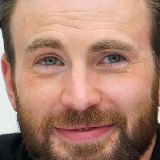

In [104]:
chris_evans

In [105]:
np.around(np.array(scarlett_johansson) / 255.0, decimals=12).shape

(160, 160, 3)

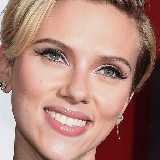

In [106]:
scarlett_johansson

# 6 - Image Verification

In [107]:
def verify(image_path, identity, database, model):
    encoding = img_to_encoding(image_path, model)
    dist = np.linalg.norm(tf.subtract(database[identity], encoding))
    if dist < 0.8:
        print("It's " + str(identity) + ", welcome in!")
        door_open = True
    else:
        print("It's not " + str(identity) + ", please go away")
        door_open = False
    return dist, door_open

In [109]:
distance, door_open_flag = verify("verif_data/scarlett_johansson28.png", "scarlett_johansson", database, FRmodel)
print("(", distance, ",", door_open_flag, ")")

It's scarlett_johansson, welcome in!
( 0.7709236 , True )


# 7 - Image Recognition

In [108]:
def who_is_it(image_path, database, model):
    
    encoding =  img_to_encoding(image_path, model)

    min_dist = 100

    for (name, db_enc) in database.items():

        dist = np.linalg.norm(tf.subtract(db_enc, encoding))

        if dist < min_dist:
            min_dist = dist
            identity = name

    if min_dist > 0.8:
        print("Not in the database.")
    else:
        print ("it's " + str(identity) + ", the distance is " + str(min_dist))

    return min_dist, identity

In [111]:
who_is_it("verif_data/scarlett_johansson28.png", database, FRmodel)

it's scarlett_johansson, the distance is 0.7709236


(0.7709236, 'scarlett_johansson')